In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from tensorflow.keras.datasets import fashion_mnist

## Building data

In [2]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images/255.0
test_images = test_images/255.0


In [3]:
# outputs 1 if the images are similar and 0 if they are different
def create_pairs(images, labels):
    paired_images = []
    paired_labels = []
    numclasses = len(np.unique(labels))
    idx = [np.where(labels==i)[0]  for i in range((numclasses))]
    for i in range(len(images)):
        img = images[i]
        img_label = labels[i]
        
        similar_img_idx = np.random.choice(idx[img_label])
        similar_img = images[similar_img_idx]
        paired_images.append([img, similar_img])
        paired_labels.append([1])
        
        dissimilar_label = np.where(labels!=img_label)[0]
        dissimilar_img_idx = np.random.choice(dissimilar_label)
        dissimilar_img = images[dissimilar_img_idx]
        paired_images.append([img, dissimilar_img])
        paired_labels.append([0])
    
    return np.array(paired_images).astype('float32'), np.array(paired_labels).astype('float32')
        

In [4]:
pairedtrainX, pairedtrainY = create_pairs(train_images, train_labels)
pairedtestX, pairedtestY = create_pairs(test_images, test_labels)

In [5]:
def visualize_data(images, labels):
    ix = random.randint(0, len(images)-1)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(images[ix][0])
    ax2.imshow(images[ix][1])
    print(labels[ix])

[1.]


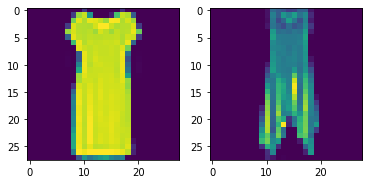

In [6]:
visualize_data(pairedtrainX, pairedtrainY)

[1.]


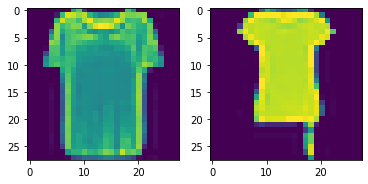

In [7]:
visualize_data(pairedtestX, pairedtestY)

## Building Siamese Network

In [8]:
def initialize_base_network():
    input_layer = tf.keras.layers.Input(shape=(28, 28, ))
    x = tf.keras.layers.Flatten()(input_layer)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    model = tf.keras.Model(input_layer, x)
    return model
    

In [9]:
import tensorflow.keras.backend as K
def euclidean_distance(vects):
    x, y = vects
    diff = K.mean(K.square(x-y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(diff, K.epsilon()))
    

In [10]:
def eucl_dist_output_shape(shapes):
    x, y = shapes
    return (x[0], 1)

In [11]:
siamese_network = initialize_base_network()
input_a = tf.keras.layers.Input(shape=(28, 28,))
vect_a = siamese_network(input_a)

input_b = tf.keras.layers.Input(shape=(28, 28,))
vect_b = siamese_network(input_b)

output_dist = tf.keras.layers.Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([vect_a, vect_b])

In [12]:
output = tf.keras.layers.Dense(1, activation="sigmoid")(output_dist)
model = tf.keras.Model([input_a, input_b], output)

In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 128)          134528      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [14]:
## Custom loss function
def contrastive_loss_with_threshold(threshold=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(threshold-y_pred, 0))
        return K.mean(y_true*square_pred + (1-y_true)*margin_square)
    return contrastive_loss

In [15]:
## custom loss function using class
from tensorflow.keras.losses import Loss
class contrastive_loss_with_threshold(Loss):
    threshold = 1
    def __init__(self, threshold=1):
        super().__init__()
        self.threshold = threshold
    def call(self, y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(self.threshold-y_pred, 0))
        return K.mean(y_true*square_pred + (1-y_true)*margin_square)

In [16]:
model.compile(loss=contrastive_loss_with_threshold(threshold=1), optimizer="adam")

In [17]:
model.fit([pairedtrainX[:, 0], pairedtrainX[:, 1]], pairedtrainY[:], 
          validation_data=([pairedtestX[:, 0], pairedtestX[:, 1]], pairedtestY[:]),
          batch_size=8, 
          epochs=10)

Train on 120000 samples, validate on 20000 samples
Epoch 1/10
120000/120000 [==============================] - 38s 319us/sample - loss: 0.2508 - val_loss: 0.2500
Epoch 2/10
120000/120000 [==============================] - 36s 303us/sample - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
120000/120000 [==============================] - 36s 303us/sample - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
120000/120000 [==============================] - 37s 304us/sample - loss: 0.1446 - val_loss: 0.0945
Epoch 5/10
120000/120000 [==============================] - 36s 303us/sample - loss: 0.0942 - val_loss: 0.0842
Epoch 6/10
120000/120000 [==============================] - 37s 305us/sample - loss: 0.0825 - val_loss: 0.0805
Epoch 7/10
120000/120000 [==============================] - 37s 306us/sample - loss: 0.0774 - val_loss: 0.0778
Epoch 8/10
120000/120000 [==============================] - 37s 307us/sample - loss: 0.0731 - val_loss: 0.0813
Epoch 9/10
120000/120000 [==============================] - 3

## Visualizing the predictions

In [37]:
def predict_data(images, labels):
    ix = random.randint(0, len(images)-1)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    pred = model.predict([np.expand_dims(images[ix][0], 0), np.expand_dims(images[ix][1], 0)])
    ax1.imshow(images[ix][0])
    ax2.imshow(images[ix][1])
    if pred[0][0]>0.5: # High distance more dissimilar
        print("dissimilar")
    if pred[0][0]<0.5: # low distance more similar
        print("similar")
#     print(pred[0], labels[ix])

dissimilar


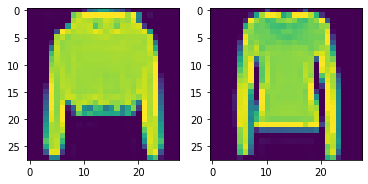

In [42]:
## For similar images the distance will be small but for dissimilar images distance will be high
predict_data(pairedtrainX, pairedtrainY)